# Assemble a full SED and derive the bolometric luminosity

Construct a hybrid full SED by combining observed spectra with a model spectrum, and then derive the bolometric luminosity. This also allows estimating the complenetess of an observed SED.

In [1]:
from astropy.io import fits, ascii
import seda
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, NullFormatter
import importlib
import os


    SEDA v0.5.1.dev3 package imported


## Observed spectra

As an example here, let's read the near-infrared IRTF/SpeX, the mid-infrared JWST/NIRSpec, and the mid-infrared Spitzer/IRS spectra for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066 in [Burgasser et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2856B/abstract), [Alejandro Merchan et al. (2025)](https://ui.adsabs.harvard.edu) and [Suárez & Metchev (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.5701S/abstract), respectively.

Read SpeX spectrum:

In [3]:
# path to the seda package
path_seda = os.path.dirname(os.path.dirname(seda.__file__))

SpeX_name = path_seda+'/docs/notebooks/data/0415-0935_IRTF_SpeX.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read JWST NIRSpec spectrum

In [6]:
NIRSpec_name = path_seda+'/docs/notebooks/data/0415-0935_NIRSpec_spectrum.dat'
NIRSpec = ascii.read(NIRSpec_name)
wl_NIRSpec = NIRSpec['wl(um)'] # um 
flux_NIRSpec = NIRSpec['flux(Jy)'] # Jy
eflux_NIRSpec = NIRSpec['eflux(Jy)'] # Jy

# convert NIRSpec fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.synthetic_photometry.convert_flux(wl=wl_NIRSpec, 
                                                          flux=flux_NIRSpec, 
                                                          eflux=eflux_NIRSpec, 
                                                          unit_in='Jy', 
                                                          unit_out='erg/s/cm2/A')
flux_NIRSpec = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_NIRSpec = out_convert_flux['eflux_out'] # in erg/s/cm2/A

# remove a few negative fluxes and edge points
mask = (flux_NIRSpec>0) & ((wl_NIRSpec<3.68) | (wl_NIRSpec>3.79))
wl_NIRSpec = wl_NIRSpec[mask]
flux_NIRSpec = flux_NIRSpec[mask]
eflux_NIRSpec = eflux_NIRSpec[mask]

# we will use later the ATMO 2020 models to complement the observations,
# and these models have low resolution (lower than the NIRSpsec R~2700), 
# so let's convolve the NIRSpec spectrum
res = 100
output_convolve_spectrum = seda.utils.convolve_spectrum(wl=wl_NIRSpec, 
                                                        flux=flux_NIRSpec, 
                                                        eflux=eflux_NIRSpec, 
                                                        res=100)
wl_NIRSpec_conv = output_convolve_spectrum['wl_conv']
flux_NIRSpec_conv = output_convolve_spectrum['flux_conv']
eflux_NIRSpec_conv = output_convolve_spectrum['eflux_conv']

Read IRS spectrum:

In [8]:
IRS_name = path_seda+'/docs/notebooks/data/0415-0935_IRS_spectrum.dat'
IRS = ascii.read(IRS_name)
wl_IRS = IRS['wl(um)'] # in um
flux_IRS = IRS['flux(Jy)'] # in Jy
eflux_IRS = IRS['eflux(Jy)'] # in Jy

# convert IRS fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.synthetic_photometry.convert_flux(wl=wl_IRS, flux=flux_IRS, 
                                                          eflux=eflux_IRS, unit_in='Jy', 
                                                          unit_out='erg/s/cm2/A')
flux_IRS = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_IRS = out_convert_flux['eflux_out'] # in erg/s/cm2/A

Plot SED to check everything looks okay:

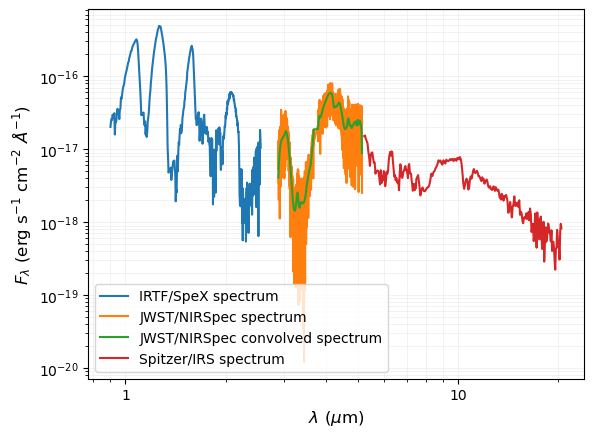

In [9]:
fig, ax = plt.subplots()

plt.plot(wl_SpeX, flux_SpeX, label='IRTF/SpeX spectrum')
plt.plot(wl_NIRSpec, flux_NIRSpec, label='JWST/NIRSpec spectrum')
plt.plot(wl_NIRSpec_conv, flux_NIRSpec_conv, label='JWST/NIRSpec convolved spectrum')
plt.plot(wl_IRS, flux_IRS, label='Spitzer/IRS spectrum')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)
ax.legend()

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

## Model spectrum

**To complement the observed SED with a model spectrum, we can follow either of the two steps below:**

- [Option 1](#OPTION-1:-Fit-model-spectra-to-the-data-and-consider-the-best-fit): Fit model spectra to the data and consider the best fit.
- [Option 2](#OPTION-2:-Generate-a-model-spectrum-with-a-given-combination-of-free-parameters): Generate a model spectrum with desired parameters from the available models.

### OPTION 1: Fit model spectra to the data and consider the best fit

To find the best model fit to the data, we can follow any of the methods below:
- Minimize the chi-square statistics following these tutorials for [a single observed spectrum](https://seda.readthedocs.io/en/latest/notebooks/tutorial_chi2_fit_single_spectrum.html) or [multiple observed spectra](https://seda.readthedocs.io/en/latest/notebooks/tutorial_chi2_fit_multiple_spectra.html).
- Run a nested sampling, as explained in these tutorials for [a single observed spectrum](https://seda.readthedocs.io/en/latest/notebooks/tutorial_bayes_fit_single_spectrum.html) or [multiple observed spectra](https://seda.readthedocs.io/en/latest/notebooks/tutorial_bayes_fit_multiple_spectra.html).

In this tutorial, let's do a chi-square minimization because it is faster and the model spectrum from the grid with the best fit should complement the observed SED similarly well as the model spectrum obtained from the nested sampling.

[Available models](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models):

In [10]:
seda.models.Models().available_models

['BT-Settl',
 'ATMO2020',
 'Sonora_Elf_Owl',
 'SM08',
 'Sonora_Bobcat',
 'Sonora_Diamondback',
 'Sonora_Cholla',
 'LB23']

**Chi-square minimization:**

In [12]:
#--------------------
# INPUT DATA
# wavelenghts
wl_spectra = [wl_SpeX, wl_NIRSpec_conv, wl_IRS] # in um
# fluxes
flux_spectra = [flux_SpeX, flux_NIRSpec_conv, flux_IRS] # in erg/s/cm2/A
# flux uncertainties
eflux_spectra = [eflux_SpeX, eflux_NIRSpec_conv, eflux_IRS] # in erg/s/cm2/A
# specify flux units
flux_unit = 'erg/s/cm2/A'
# resolution of each input spectrum (used to convolve the model spectra)
res = [100, 100, 100] # SpeX, NIRSpec, IRS

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

# load all the input data parameters
my_data = seda.input_parameters.InputData(wl_spectra=wl_spectra, 
                                          flux_spectra=flux_spectra,
                                          eflux_spectra=eflux_spectra, 
                                          flux_unit=flux_unit, res=res,
                                          distance=distance, edistance=edistance)

#--------------------
# MODEL OPTIONS
# select the atmospheric models of interest
model = 'ATMO2020'

# path to the directory or directories containing the model spectra
# (update it to your own path)
my_path = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/'
model_dir = [my_path+'NEQ_weak_spectra/',
             my_path+'CEQ_spectra/',
             my_path+'NEQ_strong_spectra/',
            ]

# set parameter ranges to select a grid subset to avoid reading the entire grid
# when a free parameter range is not specified, the whole grid range will be considered
# (use seda.Models(model).params_unique to see the model free parameters and their ranges)
params_ranges = {
    'Teff': [700, 900], # Teff range
    'logg': [4.0, 5.0] # logg range
}

# load model options
my_model = seda.input_parameters.ModelOptions(model=model, model_dir=model_dir,
                                              params_ranges=params_ranges)

#--------------------
# CHI-SQUARE OPTIONS

# load chi-square fit options
my_chi2 = seda.input_parameters.Chi2Options(my_data=my_data, my_model=my_model)

#--------------------
# RUN MINIMIZATION

output_chi2 = seda.chi2_fit.chi2(my_chi2=my_chi2)


   Input data loaded successfully:
      3 spectra

   Model options loaded successfully

      27 model spectra selected with:
         Teff range = [700, 900]
         logg range = [4.0, 5.0]


Reading, convolving, and resampling model spectra:   0%|          | 0/27 [00:00<?, ?it/s]


   Chi-square fit options loaded successfully
      elapsed time: 0.0 s

   Running chi-square fitting...


Minimizing chi-square:   0%|          | 0/27 [00:00<?, ?it/s]

      chi-square minimization results saved successfully

   Chi-square fit ran successfully
      elapsed time: 0.0 s


Visualize the best fit:

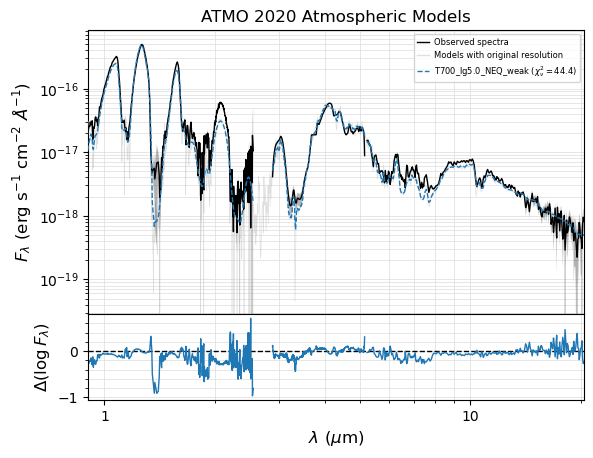

In [13]:
# plot wavelength in logarithmic scale
seda.plots.plot_chi2_fit(output_chi2, N_best_fits=1, 
                         xlog=True, ori_res=True)

Plot the reduced chi-square as a function of wavelength for the best fit:

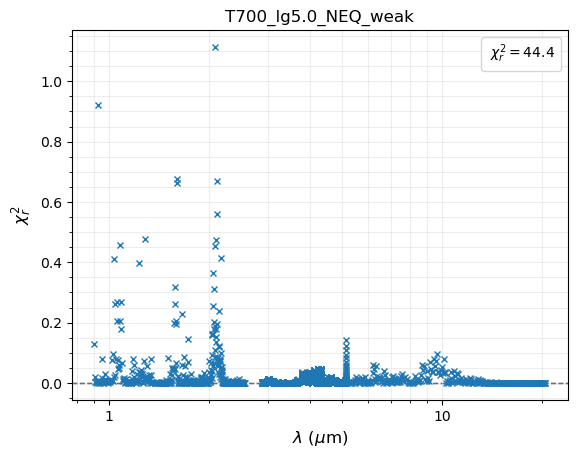

In [14]:
seda.plots.plot_chi2_red(output_chi2, N_best_fits=1, xlog=True)

## Assemble full SED and derive Lbol (from Option 1)

In [20]:
out_bol_lum = seda.phy_params.bol_lum(output_chi2, convolve_model=False)


    SEDA v0.0.0+local package imported

   Input data loaded successfully:
      3 spectra

   Model options loaded successfully

   Chi-square fit options loaded successfully
      elapsed time: 0.0 s

   Running chi-square fitting...


Minimizing chi-square:   0%|          | 0/1 [00:00<?, ?it/s]


   Chi-square fit ran successfully
      elapsed time: 0.0 s
   Gap detected between input spectra #0 and #1

log(Lbol) = -5.673\pm0.017

The observed SED is 97.4% complete

Contribution to the total observed SED (in flux or luminosity)
   spectrum #0: 51.6%
   spectrum #1: 25.0%
   spectrum #2: 23.4%
Contribution to the total hybrid full SED (in flux or luminosity)
   spectrum #0: 50.3%
   spectrum #1: 24.3%
   spectrum #2: 22.8%


Print a few relevant parameters from the hybrid SED:

In [21]:
logLbol_tot = out_bol_lum['logLbol_tot']
elogLbol_tot = out_bol_lum['elogLbol_tot']
print('\nlog(Lbol) = {:.3f}'.format(round(logLbol_tot,3))+'\pm'+'{:.3f}'.format(round(elogLbol_tot,3)))

completeness = out_bol_lum['completeness_obs']
print(f'\nThe observed SED is {round(completeness,1)}% complete')


log(Lbol) = -5.673\pm0.017

The observed SED is 97.4% complete


Plot hybrid SED used to derived Lbol:

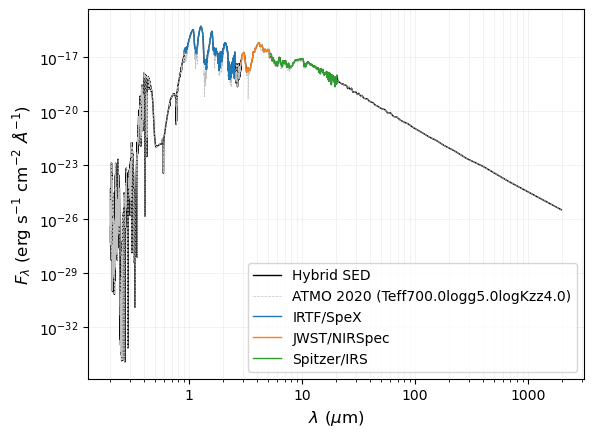

In [25]:
# set labels for input spectra and model spectrum
spectra_label = ['IRTF/SpeX', 'JWST/NIRSpec', 'Spitzer/IRS']
model_label = 'ATMO 2020'

seda.plots.plot_full_SED(out_bol_lum, spectra_label=spectra_label, 
                         model_label=model_label)

### OPTION 2: Generate a model spectrum with a given combination of free parameters

Generate a model spectrum from any available model grid with parameters indicated by the user.

This is useful for reading a model with a combination of parameters that could have been constrained by alternative methods, or simply for testing how Lbol changes when using models with different parameters.

[Available models](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models):

In [26]:
seda.models.Models().available_models

['BT-Settl',
 'ATMO2020',
 'Sonora_Elf_Owl',
 'SM08',
 'Sonora_Bobcat',
 'Sonora_Diamondback',
 'Sonora_Cholla',
 'LB23']

In [27]:
# select the atmospheric models of interest
model = 'ATMO2020'

# path to the directory or directories containing the model spectra
# (update it to your own path)
my_path = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/'
model_dir = [my_path+'NEQ_weak_spectra/',
             my_path+'CEQ_spectra/',
             my_path+'NEQ_strong_spectra/',
            ]

# parameters to generate the model spectrum
# (use seda.Models(model).params_unique to see the model free parameters and their ranges)
# as an example, let's consider values between the grid points and that are reasonable for the target
params = {'Teff': 757, 'logg': 5.33, 'logKzz': 3.53}

# generate the desired model spectrum
out = seda.utils.generate_model_spectrum(model=model, params=params, 
                                         model_dir=model_dir, 
                                         save_spectrum=True)
wl_model = out['wavelength'] # micron
flux_model = out['flux'] # erg/s/cm2/A


      510 model spectra

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [5.  5.5]
         logKzz range = [0. 4.]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


Show model spectrum:

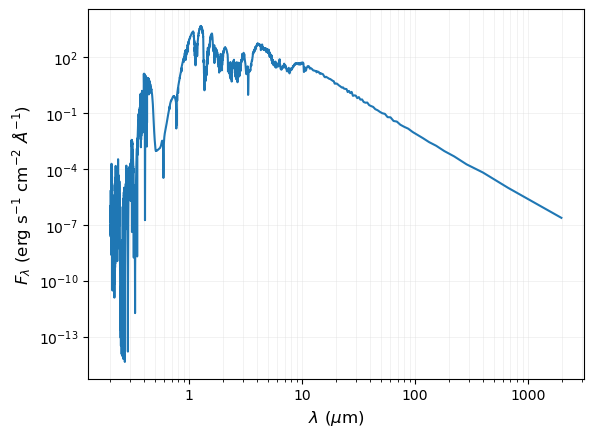

In [28]:
fig, ax = plt.subplots()

plt.plot(wl_model, flux_model)

plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

## Assemble full SED and derive Lbol (from Option 2)

In [29]:
# wavelenghts
wl_spectra = [wl_SpeX, wl_NIRSpec_conv, wl_IRS] # in um
# fluxes
flux_spectra = [flux_SpeX, flux_NIRSpec_conv, flux_IRS] # in erg/s/cm2/A
# flux uncertainties
eflux_spectra = [eflux_SpeX, eflux_NIRSpec_conv, eflux_IRS] # in erg/s/cm2/A
# specify flux units
flux_unit = 'erg/s/cm2/A'
# resolution of each input spectrum (used to convolve the model spectra)
res = [100, 100, 100] # SpeX, NIRSpec, IRS

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

out_bol_lum = seda.phy_params.bol_lum(wl_spectra=wl_spectra, flux_spectra=flux_spectra, 
                                      eflux_spectra=eflux_spectra, flux_unit=flux_unit, 
                                      distance=distance, edistance=edistance, res=res, 
                                      wl_model=wl_model, flux_model=flux_model, 
                                      params=params, convolve_model=False)


   Input data loaded successfully:
      3 spectra

   Input data loaded successfully:
      3 spectra

   Model options loaded successfully

   Chi-square fit options loaded successfully
      elapsed time: 0.0 s

   Running chi-square fitting...


Minimizing chi-square:   0%|          | 0/1 [00:00<?, ?it/s]


   Chi-square fit ran successfully
      elapsed time: 0.0 s
   Gap detected between input spectra #0 and #1

log(Lbol) = -5.674\pm0.017

The observed SED is 97.7% complete

Contribution to the total observed SED (in flux or luminosity)
   spectrum #0: 51.6%
   spectrum #1: 25.0%
   spectrum #2: 23.4%
Contribution to the total hybrid full SED (in flux or luminosity)
   spectrum #0: 50.4%
   spectrum #1: 24.4%
   spectrum #2: 22.9%


Print a few relevant parameters from the hybrid SED:

In [30]:
logLbol_tot = out_bol_lum['logLbol_tot']
elogLbol_tot = out_bol_lum['elogLbol_tot']
print('\nlog(Lbol) = {:.3f}'.format(round(logLbol_tot,3))+'\pm'+'{:.3f}'.format(round(elogLbol_tot,3)))

completeness = out_bol_lum['completeness_obs']
print(f'\nThe observed SED is {round(completeness,1)}% complete')


log(Lbol) = -5.674\pm0.017

The observed SED is 97.7% complete


Plot hybrid SED used to derived Lbol:

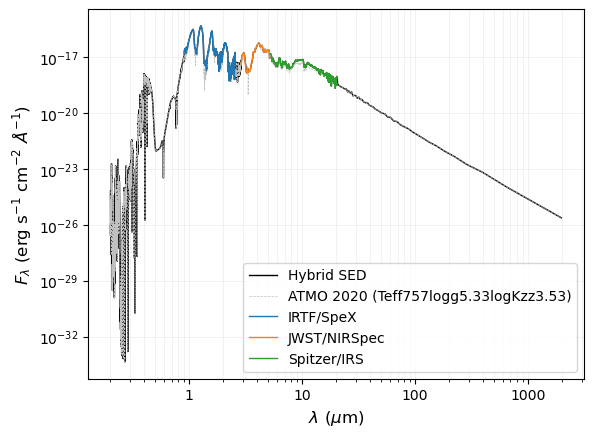

In [31]:
# set labels for input spectra and model spectrum
spectra_label = ['IRTF/SpeX', 'JWST/NIRSpec', 'Spitzer/IRS']
model_label = 'ATMO 2020'

seda.plots.plot_full_SED(out_bol_lum, spectra_label=spectra_label, 
                         model_label=model_label)